## Human Activity Recognition - Estudo de Caso

Aplicação de reconhecimento de atividades humanas (Human Activity Recognition) com o objetivo de mostrar a implementação de conceitos importantes de Aprendizado Federado em um sistema.

In [ ]:
# Clonando o repositório onde estão presentes os dados de treinamento e teste
!git clone https://github.com/EduardaChagas/Aprendizado-Federado-aplicado-IOT af

Cloning into 'af'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 51 (delta 22), reused 36 (delta 12), pack-reused 0
Receiving objects: 100% (51/51), 2.55 MiB | 6.93 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from joblib import Parallel, delayed
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
# Modelo de rede neural convolucional que será aplicado ao HAR
class HARmodel:
    @staticmethod
    def create_model(input_size = 40, num_classes = 5):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(input_size, 1)),
            tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes)
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        return model

### Carregamento do Conjunto de Dados

In [ ]:
def load_data(client_id, total_clients, verbose=True):
    training_data = pd.read_csv(r'/content/af/data/pml-training.csv', low_memory=False)
    testing_data = pd.read_csv(r'/content/af/data/pml-testing.csv', low_memory=False)

    training_data = training_data.sample(frac=1, random_state=43)

    parts = ["belt", "arm", "dumbbell", "forearm"]
    variables = ["roll_{}", "pitch_{}", "yaw_{}", "total_accel_{}", "accel_{}_x", "accel_{}_y",
                 "accel_{}_z", "gyros_{}_x", "gyros_{}_y", "gyros_{}_z"]

    training_columns = [variable.format(part) for variable in variables for part in parts]

    training_x = training_data[training_columns]
    training_y = training_data['classe']

    testing_x = testing_data[training_columns]
    testing_y = testing_data['classe']

    training_x = training_x.astype('float32')
    testing_x = testing_x.astype('float32')

    label_encoder = LabelEncoder()
    label_encoder.fit(pd.concat([training_y, testing_y], axis=0))

    training_y = label_encoder.transform(training_y)
    testing_y = label_encoder.transform(testing_y)

    training_rows_per_client = len(training_x) // total_clients

    # print(training_rows_per_client)

    begin_index = training_rows_per_client * client_id
    end_index = training_rows_per_client * (client_id + 1)

    if verbose == True:
        print("{:^54}".format('\033[34;1m' + 'Cliente %d' % (client_id + 1) + '\033[37;0m'))
        print("{:^40}".format('Linhas %d -> %d' % (begin_index, end_index)) + '\n')

    return (
        training_x[begin_index:end_index],
        training_y[begin_index:end_index]
        ), \
        (testing_x, testing_y)

### Classe do Cliente

In [ ]:
class Client():
    def __init__(self, cid):
        self.cid = int(cid)
        self.model = HARmodel.create_model()

        (self.x_train, self.y_train), (self.x_test, self.y_test) = self.load_data()


    def load_data(self):
        return load_data(self.cid, TOTAL_CLIENTS)


    def fit(self, parameters, config=None):
        self.model.set_weights(parameters)
        history = self.model.fit(self.x_train, self.y_train, epochs=5, batch_size=128,
                                    validation_data=(self.x_test, self.y_test), verbose=False)
        sample_size = len(self.x_train)
        # print(f"{self.cid} -> {history.history['val_accuracy'][-1]}")
        print(f"Acurácia: {history.history['val_accuracy'][-1]}")

        return self.model.get_weights(), sample_size, {"val_accuracy": history.history['val_accuracy'][-1],
                                                        "val_loss": history.history['val_loss'][-1]}


    def evaluate(self, parameters):
        self.model.set_weights(parameters)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Classe do Servidor

In [ ]:
class Server():
    def __init__(self, n_rounds, total_number_clients, min_fit_clients):
        self.n_rounds = n_rounds
        self.total_number_clients = total_number_clients
        self.min_fit_clients = min_fit_clients

        self.server_round = 0
        self.selected_clients = []
        self.model = HARmodel.create_model()
        self.w_global = self.model.get_weights()

        self.clients_model_list = []
        self.create_models()
        _, (self.x_test, self.y_test) = load_data(0, 1, verbose=False)


    def create_models(self):
        print(' ')
        for i in range(self.total_number_clients):
            # print("Criando cliente = %d" % i)
            self.clients_model_list.append(Client(i))


    def aggregate_fit(self, weight_list, sample_sizes):
        self.w_global = []
        for weights in zip(*weight_list):
            weighted_sum = 0
            total_samples = sum(sample_sizes)
            for i in range(len(weights)):
                weighted_sum += weights[i] * sample_sizes[i]
            self.w_global.append(weighted_sum / total_samples)


    def configure_fit(self):
        self.selected_clients = np.random.permutation(list(range(self.total_number_clients)))[:self.min_fit_clients]
        print(f"Clientes selecionados: \033[34;1m{np.array(self.selected_clients) + 1}\033[37;0m")


    def fit(self):
        weight_list, sample_sizes_list, info_list = [], [], []
        for i, pos in enumerate(self.selected_clients):
            # print(f"-------> [{i+1}] (Rodada: {self.server_round+1}/{self.n_rounds}) Cliente ID: {pos+1}")
            print(f"--------> Cliente ID: {pos+1}")
            weights, size, info = self.clients_model_list[pos].fit(parameters=self.w_global)
            weight_list.append(weights)
            sample_sizes_list.append(size)
            info_list.append(info)
        return weight_list, sample_sizes_list, {"acc_loss_local":[(pos+1, info_list[i]) for i, pos in enumerate(self.selected_clients)]}


    def centralized_evaluation(self):
        self.model.set_weights(self.w_global)
        return self.model.evaluate(self.x_test, self.y_test, verbose=False)

### Exemplo de Execução

In [ ]:
# Parâmetros
TOTAL_CLIENTS = 10
CLIENTS_PER_ROUND = 3
NUMBER_OF_ROUNDS = 100

In [ ]:
print('\n' + '='*40)
print("{:^54}".format('\033[;1m' + 'CARREGAMENTO DE DADOS' + '\033[37;0m'))
print("{:^40}".format(f'Número total de clientes: {TOTAL_CLIENTS}' + '\n'))

s = Server(n_rounds=NUMBER_OF_ROUNDS,
           total_number_clients=TOTAL_CLIENTS,
           min_fit_clients=CLIENTS_PER_ROUND)

print('\n' + '='*40)
print("{:^54}".format('\033[;1m' + 'INICIANDO' + '\033[37;0m'))
print("{:^40}".format(f'Clientes por rodada: {CLIENTS_PER_ROUND} ' + '\n'))

evaluate_list = {"distributed": {"loss":[], "accuracy":[]}, "centralized": {"loss":[], "accuracy":[]}}

# Rodadas de comunicação
for s.server_round in range(s.n_rounds):
    print('\033[;1m' + f'Rodada {s.server_round+1}/{s.n_rounds}' + '\033[37;0m')

    # Seleciona os clientes que participarão da próxima rodada de comunicação
    s.configure_fit()

    # Treinamento local do dispositivo
    weight_list, sample_sizes, info = s.fit()

    # Agregação
    s.aggregate_fit(weight_list, sample_sizes)

    print('\033[3;1m' + '-'*40 + '\033[37;0m')
    print(f"Avaliação centralizada")
    evaluate_loss, evaluate_accuracy = s.centralized_evaluation()
    print(f"evaluate_accuracy: {evaluate_accuracy}")
    evaluate_list["centralized"]["loss"].append(evaluate_loss)
    evaluate_list["centralized"]["accuracy"].append(evaluate_accuracy)
    print('\033[3;1m' + '-'*40 + '\033[37;0m' + '\n')

print('\n\n' + '='*40)
print("{:^54}".format('\033[;1m' + 'RESULTADOS FINAIS' + '\033[37;0m'))
print(f"\nCentralized loss: ", end='')
print(evaluate_list["centralized"]["loss"])
print(f"Centralized accuracy: ", end='')
print(evaluate_list["centralized"]["accuracy"])


          CARREGAMENTO DE DADOS           
     Número total de clientes: 10
      
 
               Cliente 1                
            Linhas 0 -> 1962            

               Cliente 2                
          Linhas 1962 -> 3924           

               Cliente 3                
          Linhas 3924 -> 5886           

               Cliente 4                
          Linhas 5886 -> 7848           

               Cliente 5                
          Linhas 7848 -> 9810           

               Cliente 6                
          Linhas 9810 -> 11772          

               Cliente 7                
         Linhas 11772 -> 13734          

               Cliente 8                
         Linhas 13734 -> 15696          

               Cliente 9                
         Linhas 15696 -> 17658          

               Cliente 10               
         Linhas 17658 -> 19620          


                INICIANDO                 
        Clientes por rodada: 3 
       

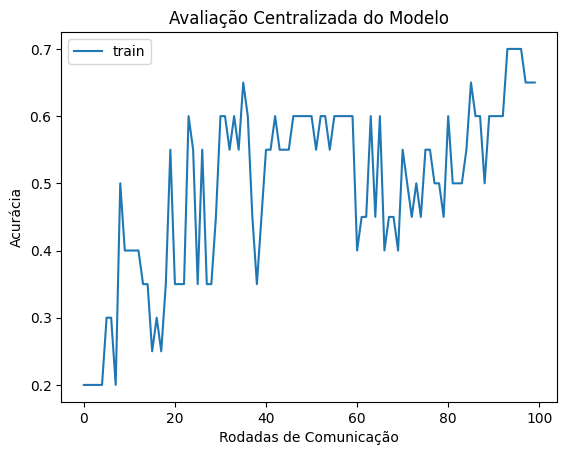

In [ ]:
plt.title('Avaliação Centralizada do Modelo')
plt.plot(evaluate_list["centralized"]["accuracy"])
plt.ylabel('Acurácia')
plt.xlabel('Rodadas de Comunicação')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

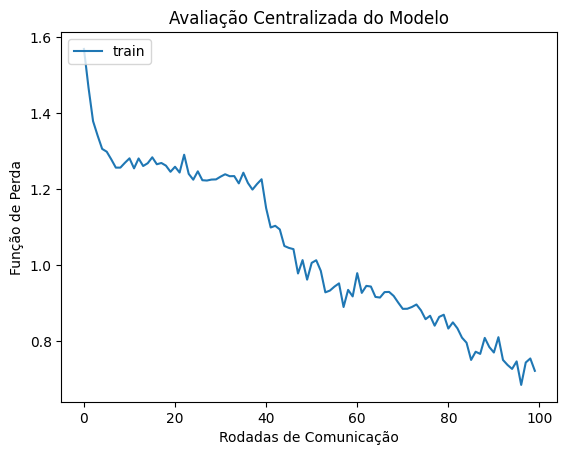

In [ ]:
plt.title('Avaliação Centralizada do Modelo')
plt.plot(evaluate_list["centralized"]["loss"])
plt.ylabel('Função de Perda')
plt.xlabel('Rodadas de Comunicação')
plt.legend(['train', 'test'], loc='upper left')
plt.show()